<a href="https://colab.research.google.com/github/Eiko58/ML-in-Finance/blob/main/solution5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as s

## **European Option**

In [3]:
class EuropeanCallOption(object):
    def __init__(self, S0, K, r, T, sigma,M,I):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.M = M
        self.I = I
    def value(self):
        d1 = (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = (np.log(self.S0 / self.K) + (self.r - 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
        value = (self.S0 * s.norm.cdf(d1, 0, 1) - self.K * np.exp(-self.r * self.T) * s.norm.cdf(d2, 0, 1))
        return value
    def simulation(self):

        dt = self.T / self.M
        S = np.zeros((self.M + 1, self.I))
        payoff = np.zeros((self.M + 1, self.I))
        S[0] = self.S0
        for t in range(1, self.M + 1):
            z = np.random.standard_normal(self.I)
            S[t] = S[t - 1] * np.exp((self.r - 0.5 * self.sigma ** 2) * dt + self.sigma * np.sqrt(dt) * z)
            payoff[t] = np.maximum(S[t] - self.K, 0)
        return S,payoff


8.173260527445477
8.021352235143176


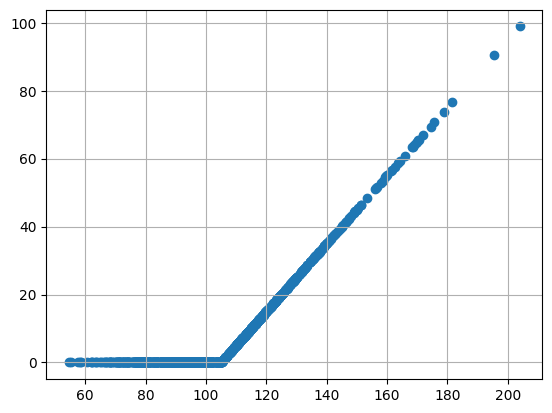

In [4]:
prices,payoff = EuropeanCallOption(100, 105, 0.05, 1, 0.2, 100000, 1000).simulation()
option_price = np.mean(payoff[-1])*np.exp(-0.05*1)
BS_price = EuropeanCallOption(100, 105, 0.05, 1, 0.2, 100000, 1000).value()
plt.scatter(prices[-1],payoff[-1])
plt.grid()
print(option_price)
print(BS_price)

## **Digital Option**

In [5]:
class DigitalCallOption(object):
    def __init__(self, S0, K, r, T, sigma,Q, M, I):
        self.S0 = S0
        self.K = K
        self.r = r
        self.T = T
        self.sigma = sigma
        self.Q = Q
        self.M = M
        self.I = I
    def value(self):
      d2 = (np.log(self.S0 / self.K) + (self.r - 0.5 * self.sigma ** 2) * self.T) / (self.sigma * np.sqrt(self.T))
      value = self.Q * s.norm.cdf(d2, 0, 1) * np.exp(-self.r * self.T)
      return value
    def simulation(self):
        dt = self.T / self.M
        S = np.zeros((self.M + 1, self.I))
        payoff = np.zeros((self.M + 1, self.I))
        S[0] = self.S0
        for t in range(1, self.M + 1):
            z = np.random.standard_normal(self.I)
            S[t] = S[t - 1] * np.exp((self.r - 0.5 * self.sigma ** 2) * dt + self.sigma * np.sqrt(dt) * z)
            for i in range(self.I):
                if S[t,i] > self.K:
                    payoff[t, i] = 1
                else:
                    payoff[t, i] = 0
        return S, payoff


2.200070529682731
2.1402662051266064


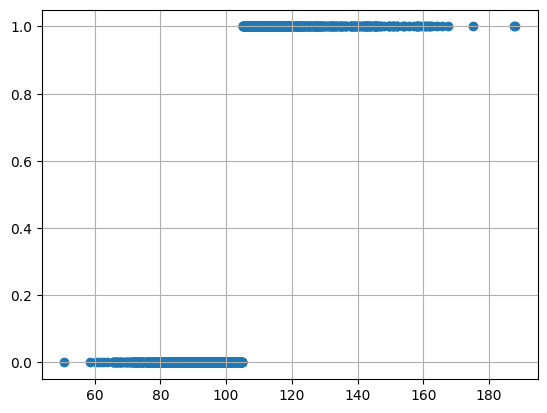

In [6]:
prices,payoff = DigitalCallOption(100, 105, 0.05, 1.0, 0.2,5,5000,1000).simulation()
option_price = np.sum(payoff[-1])/1000 * 5 * np.exp(-0.05 * 1)
BS_price = DigitalCallOption(100, 105, 0.05, 1.0, 0.2,5,5000,1000).value()
plt.scatter(prices[-1],payoff[-1])
plt.grid()
print(BS_price)
print(option_price)

## **Heston Model Simulation**

In [7]:
class HestonModel(object):
    def __init__(self,S, T, r, kappa, theta, v_0, rho, xi, steps, Npaths):
      self.S = S
      self.v_0 = v_0
      self.T = T
      self.r = r
      self.kappa = kappa
      self.theta = theta
      self.rho = rho
      self.xi = xi
      self.steps = steps
      self.Npaths = Npaths

    def heston_paths(self):
      S_t = self.S
      v_t = self.v_0
      dt = self.T/self.steps
      prices = np.zeros((self.Npaths,self.steps))
      sigs = np.zeros((self.Npaths,self.steps))
      for t in range(self.steps):
        WT = np.random.multivariate_normal(np.array([0,0]),
                                           cov = np.array([[1,self.rho],
                                                          [self.rho,1]]),
                                           size=self.Npaths) * np.sqrt(dt)

        S_t = S_t*(np.exp( (self.r - 0.5* v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) )
        v_t = np.abs(v_t + self.kappa*(self.theta-v_t)*dt + self.xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
      return prices,sigs



In [8]:
S_p,V_p = HestonModel(100, 1, 0.02, 4.0, 0.02, 0.02, 0.7, 0.9, 10000, 100).heston_paths()
S_n,V_n = HestonModel(100, 1, 0.02, 4.0, 0.02, 0.02, -0.7, 0.9, 10000, 100).heston_paths()

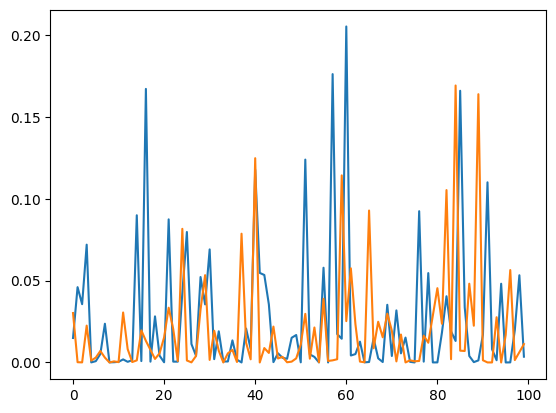

In [9]:
plt.plot(V_p[:,-1])
plt.plot(V_n[:,-1])

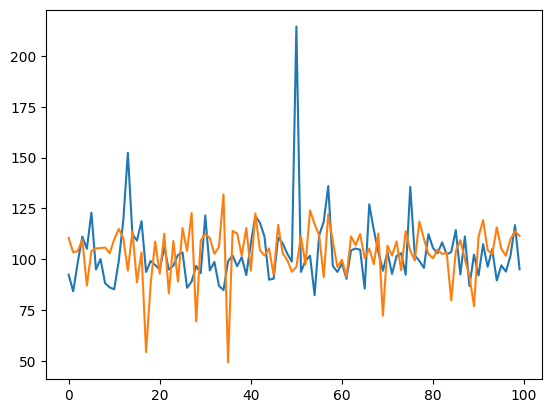

In [10]:
plt.plot(S_p[:,-1])
plt.plot(S_n[:,-1])


In [11]:
S_gbm,p = DigitalCallOption(100, 105, 0.02, 1.0, 0.2,5,5000,100).simulation()

Text(0, 0.5, 'Density')

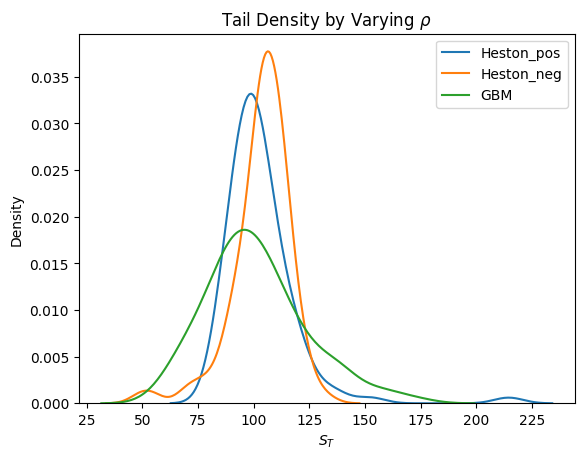

In [12]:
import seaborn as sns

fig, ax = plt.subplots()

ax = sns.kdeplot(data=S_p[:,-1], label="Heston_pos", ax=ax)
ax = sns.kdeplot(data=S_n[:,-1], label="Heston_neg", ax=ax)
ax = sns.kdeplot(data=S_gbm[-1], label="GBM", ax=ax)

ax.set_title(r'Tail Density by Varying $\rho$')
plt.legend()
plt.xlabel('$S_T$')
plt.ylabel('Density')